In [1]:
Z_DIM = 2
N_BATCH = 32
N_EPOCH = 200
LEARNING_RATE = 0.0004
R_LOSS_FACTOR = 1000
N_THREAD = 2

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import numpy as np

In [3]:
# For reproducible experiments
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
# torch.use_deterministic_algorithms(True)

# Get a working device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Fashion MNIST

In [4]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

train_data, val_data = random_split(train_data, [0.9, 0.1])

train_data_loader = DataLoader(
    train_data,
    batch_size=N_BATCH,
    shuffle=True,
    num_workers=N_THREAD
)
val_data_loader = DataLoader(
    val_data,
    batch_size=N_BATCH,
    shuffle=True,
    num_workers=N_THREAD
)
test_data_loader = DataLoader(
    test_data,
    batch_size=N_BATCH,
    shuffle=True,
    num_workers=N_THREAD
)

print()
print("train_data:", len(train_data_loader.dataset))
print("val_data:", len(val_data_loader.dataset))
print("test_data:", len(test_data_loader.dataset))


train_data: 54000
val_data: 6000
test_data: 10000


## Helper class
- EarlyStopping
- Trainer

In [5]:
import time
import os
from tqdm import tqdm
from abc import ABC, abstractmethod


class ModelTracker:
    def __init__(self, model, save_path, patience=3, delta=0.001, verbose=True):
        self._early_stop = False
        self._model = model
        self._patience = patience
        self._verbose = verbose
        self._counter = 0
        self._best_score = -np.inf
        self._delta = delta
        self._save_path = save_path
        self._val_loss_min = np.inf
        os.makedirs(save_path, exist_ok=True)

    def early_stop(self, val_loss, epoch):
        score = -val_loss
        if score < self._best_score + self._delta:
            self._counter += 1
            print(f'\nEarly Stopping counter: {self._counter} out of {self._patience}')
            if self._counter >= self._patience:
                self._early_stop = True
        else:
            self._best_score = score
            if self._verbose:
                print(f'\nSaving model to checkpoint... (Validate loss: {self._val_loss_min:.5f} --> {val_loss:.5f})')
            self.save_checkpoint(f"model.{epoch}.pt")
            self._val_loss_min = val_loss
            self._counter = 0
        return self._early_stop

    def save_checkpoint(self, filename="model.pt"):
        fp = os.path.join(self._save_path, filename)
        torch.save(self._model.state_dict(), fp)


class Model(nn.Module, ABC):
    @abstractmethod
    def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return prediction and loss
        """
        pass

    @abstractmethod
    def loss_fn(self, *args) -> torch.Tensor:
        pass

    def predict(self, X) -> torch.Tensor:
        with torch.no_grad():
            pred, _ = self.forward(X)
        return pred


class Trainer:
    def __init__(self, model: Model, tracker: ModelTracker, train_data_loader, val_data_loader, test_data_loader,
                 device):
        self.model = model
        self.device = device
        self.train_data_loader = train_data_loader
        self.val_data_loader = val_data_loader
        self.test_data_loader = test_data_loader
        self.tracker = tracker
        self.optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    def fit(self):
        """
        Train the model.
        """
        start = time.time()
        for epoch in range(1, N_EPOCH + 1):
            print(f"Epoch {epoch}/{N_EPOCH}\n-------------------------------")
            train_loss = self._train(epoch)
            val_loss = self._validate()
            early_stop = self.tracker.early_stop(val_loss, epoch)
            print(f"Train loss: {train_loss:.5f}")
            print(f"Validate loss: {val_loss:.5f}")
            print("===============================\n")
            if early_stop:
                print("Early stopping now...")
                break
        self.tracker.save_checkpoint()
        print(f"Training complete! Elapsed time: {time.time() - start:.1f}s")

    def test(self):
        """
        Evaluate the model's performance.
        """
        start = time.time()
        loss = self._validate(test=True)
        print(f"\nTest loss: {loss:.5f} \n")
        print(f"Test complete! Elapsed time: {time.time() - start:.1f}s")

    def _train(self, epoch) -> float:
        """
        Returns average training loss
        """
        dataloader = self.train_data_loader
        size = len(dataloader.dataset)
        progress = tqdm(enumerate(dataloader), total=int(size / dataloader.batch_size))
        loss_sum = 0
        self.model.train()
        for batch, (X, _) in progress:
            X = X.to(self.device)
            self.optimizer.zero_grad()
            pred, loss = self.model(X)
            loss = loss.mean()
            loss.backward()
            self.optimizer.step()
            loss = loss.item()
            loss_sum += loss
            if batch % 100 == 0:
                progress.set_description(f"[Train loss: {loss:.5f}]")
        avg_loss = loss_sum / len(dataloader)
        return avg_loss

    def _validate(self, test=False) -> float:
        """
        Returns average validate/test loss
        """
        dataloader = self.train_data_loader
        size = len(dataloader.dataset)
        progress = tqdm(enumerate(dataloader), total=int(size / dataloader.batch_size))
        self.model.eval()
        loss_sum = 0
        with torch.no_grad():
            for batch, (X, _) in progress:
                X = X.to(self.device)
                pred, loss = self.model(X)
                loss = loss.mean().item()
                loss_sum += loss
                if batch % 100 == 0:
                    if test:
                        progress.set_description(f"[Validate loss: {loss:.5f}]")
                    else:
                        progress.set_description(f"[Test loss: {loss:.5f}]")
        avg_loss = loss_sum / len(dataloader)
        return avg_loss

## VAE
Variational AutoEncoder
```
shape:  (N, C, H, W)
input:  (N, 1, 28, 28)
conv_0: (N, 1, 28, 28)  => (N, 32, 28, 28) [p=1]
conv_1: (N, 32, 28, 28) => (N, 64, 14, 14) [p=1]
conv_2: (N, 64, 14, 14) => (N, 64, 7, 7)   [p=1]
conv_3: (N, 64, 7, 7)   => (N, 64, 7, 7)   [p=1]
```

In [6]:
conv_options = {
    'n_layers': 4,
    'in_channels': [1, 32, 64, 64],
    'out_channels': [32, 64, 64, 64],
    'kernel_sizes': [3, 3, 3, 3],
    'strides': [1, 2, 2, 1],
    'padding': [1, 1, 1, 1],
    'feature_shape': (64, 7, 7)
}


class Encoder(nn.Module):
    def __init__(self, conv_options, z_dim: int, batch_norm=True, dropout=0.1):
        super().__init__()
        self.z_dim = z_dim
        self.activation = nn.LeakyReLU()
        self.drop_out = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        self.conv_layer = nn.ModuleList()
        self.batch_norm = nn.ModuleList()
        self.flatten = nn.Flatten()
        self.mu = nn.Linear(np.prod(conv_options['feature_shape']), self.z_dim)
        self.log_var = nn.Linear(np.prod(conv_options['feature_shape']), self.z_dim)

        for i in range(conv_options['n_layers']):
            layer = nn.Conv2d(
                in_channels=conv_options['in_channels'][i],
                out_channels=conv_options['out_channels'][i],
                kernel_size=conv_options['kernel_sizes'][i],
                stride=conv_options['strides'][i],
                padding=conv_options['padding'][i]
            )
            self.conv_layer.append(layer)
            if batch_norm:
                C = conv_options['out_channels'][i]
                self.batch_norm.append(nn.BatchNorm2d(num_features=C))
            else:
                self.batch_norm.append(nn.Identity())

    def forward(self, x):
        for i, conv2d in enumerate(self.conv_layer):
            x = conv2d(x)
            x = self.batch_norm[i](x)
            x = self.activation(x)
            x = self.drop_out(x)

        x = self.flatten(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var


class VariationalSampler(nn.Module):
    def __init__(self, z_dim: int):
        super().__init__()
        self.z_dim = z_dim

    def forward(self, mu, log_var):
        epsilon = torch.randn_like(mu)
        z = mu + torch.exp(0.5 * log_var) * epsilon
        return z


class Decoder(nn.Module):
    def __init__(self, conv_options, z_dim: int, batch_norm=True, dropout=0.25):
        super().__init__()
        self.activation = nn.LeakyReLU()
        self.drop_out = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        self.conv_layer = nn.ModuleList()
        self.batch_norm = nn.ModuleList()
        self.sigmoid = nn.Sigmoid()
        self.to_feature_shape = nn.Linear(z_dim, np.prod(conv_options['feature_shape']))
        self.unflatten = nn.Unflatten(1, conv_options['feature_shape'])

        in_channels = conv_options['in_channels'][::-1]
        out_channels = conv_options['out_channels'][::-1]
        kernel_sizes = conv_options['kernel_sizes'][::-1]
        strides = conv_options['strides'][::-1]
        padding = conv_options['padding'][::-1]

        for i in range(conv_options['n_layers']):
            layer = nn.ConvTranspose2d(
                in_channels=out_channels[i],
                out_channels=in_channels[i],
                kernel_size=kernel_sizes[i],
                stride=strides[i],
                padding=padding[i],
                # fix ambiguity of conv2d output with stride > 1
                output_padding=1 if strides[i] > 1 else 0
            )
            self.conv_layer.append(layer)
            if batch_norm:
                # Don't apply batch_norm on the last layer
                if i + 1 < conv_options['n_layers']:
                    C = in_channels[i]
                    self.batch_norm.append(nn.BatchNorm2d(num_features=C))
                    continue
            self.batch_norm.append(nn.Identity())

    def forward(self, z):
        x = self.to_feature_shape(z)
        x = self.unflatten(x)

        for i, convT2d in enumerate(self.conv_layer):
            x = convT2d(x)
            if i + 1 < len(self.conv_layer):
                x = self.batch_norm[i](x)
                x = self.activation(x)
                x = self.drop_out(x)
            else:
                x = self.sigmoid(x)
        return x


class VariationalAutoEncoder(Model):
    def __init__(self, conv_options, z_dim, r_loss_factor=1000):
        super().__init__()
        self.r_loss_factor = r_loss_factor
        self.encoder = Encoder(conv_options, z_dim=z_dim)
        self.sampler = VariationalSampler(z_dim=z_dim)
        self.decoder = Decoder(conv_options, z_dim=z_dim)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampler(mu, log_var)
        x_hat = self.decoder(z)
        loss = self.loss_fn(x, x_hat, mu, log_var)
        return x_hat, loss

    def loss_fn(self, x, x_hat, mu, log_var):
        reconstruction_loss = torch.mean(torch.square(x_hat - x), dim=(1, 2, 3))
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=tuple(range(1, mu.ndim)))
        return self.r_loss_factor * reconstruction_loss + kl_divergence


model = VariationalAutoEncoder(conv_options, z_dim=Z_DIM).to(device)

print(model)

VariationalAutoEncoder(
  (encoder): Encoder(
    (activation): LeakyReLU(negative_slope=0.01)
    (drop_out): Dropout2d(p=0.1, inplace=False)
    (conv_layer): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (batch_norm): ModuleList(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1-3): 3 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (mu): Linear(in_features=3136, out_features=2, bias=True)
    (log_var): Linear(in_features=3136, out_features=2, bias=True)
  )
  (sampler): VariationalSampler()
  (decoder): Decoder(
    (activation): LeakyReLU(negative_slope=0.01)
    

In [7]:
tracker = ModelTracker(
    model=model,
    delta=0.01,
    save_path="./checkpoints",
)
trainer = Trainer(model, tracker, train_data_loader, val_data_loader, test_data_loader, device=device)
trainer.fit()

Epoch 1/200
-------------------------------


[Train loss: 45.72490]: : 1688it [00:12, 131.38it/s]                        
[Test loss: 36.91703]: : 1688it [00:04, 413.39it/s]                        


Saving model to checkpoint... (Validate loss: inf --> 41.52176)
Train loss: 53.37659
Validate loss: 41.52176

Epoch 2/200
-------------------------------



[Train loss: 47.05427]: : 1688it [00:09, 183.37it/s]                        
[Test loss: 44.16428]: : 1688it [00:04, 420.44it/s]                        


Saving model to checkpoint... (Validate loss: 41.52176 --> 40.21219)
Train loss: 42.91042
Validate loss: 40.21219

Epoch 3/200
-------------------------------



[Train loss: 40.01415]: : 1688it [00:10, 156.46it/s]                        
[Test loss: 35.59595]: : 1688it [00:07, 215.94it/s]                        



Saving model to checkpoint... (Validate loss: 40.21219 --> 38.22935)
Train loss: 41.35271
Validate loss: 38.22935

Epoch 4/200
-------------------------------


[Train loss: 38.57071]: : 1688it [00:11, 152.94it/s]                        
[Test loss: 36.40196]: : 1688it [00:04, 380.67it/s]                        


Saving model to checkpoint... (Validate loss: 38.22935 --> 37.73352)
Train loss: 40.46326
Validate loss: 37.73352

Epoch 5/200
-------------------------------



[Train loss: 40.40308]: : 1688it [00:10, 159.46it/s]                        
[Test loss: 39.83040]: : 1688it [00:07, 224.88it/s]                        


Early Stopping counter: 1 out of 3
Train loss: 39.81801
Validate loss: 37.84660

Epoch 6/200
-------------------------------



[Train loss: 42.40340]: : 1688it [00:10, 168.15it/s]                        
[Test loss: 34.74716]: : 1688it [00:04, 376.04it/s]                        



Saving model to checkpoint... (Validate loss: 37.73352 --> 36.78979)
Train loss: 39.30500
Validate loss: 36.78979

Epoch 7/200
-------------------------------


[Train loss: 42.37480]: : 1688it [00:10, 167.31it/s]                        
[Test loss: 38.49598]: : 1688it [00:04, 374.08it/s]                        


Early Stopping counter: 1 out of 3
Train loss: 39.04403
Validate loss: 37.89282

Epoch 8/200
-------------------------------



[Train loss: 34.67290]: : 1688it [00:13, 126.64it/s]                        
[Test loss: 36.07203]: : 1688it [00:04, 369.67it/s]                        


Saving model to checkpoint... (Validate loss: 36.78979 --> 36.76245)
Train loss: 38.67478
Validate loss: 36.76245

Epoch 9/200
-------------------------------



[Train loss: 36.56384]: : 1688it [00:10, 165.31it/s]                        
[Test loss: 36.03470]: : 1688it [00:04, 377.99it/s]                        


Saving model to checkpoint... (Validate loss: 36.76245 --> 36.49049)
Train loss: 38.45650
Validate loss: 36.49049

Epoch 10/200
-------------------------------



[Train loss: 34.02666]: : 1688it [00:12, 131.57it/s]                        
[Test loss: 41.26073]: : 1688it [00:04, 379.49it/s]                        


Early Stopping counter: 1 out of 3
Train loss: 38.18488
Validate loss: 37.51775

Epoch 11/200
-------------------------------



[Train loss: 38.22393]: : 1688it [00:10, 167.57it/s]                        
[Test loss: 34.57875]: : 1688it [00:04, 371.62it/s]                        


Saving model to checkpoint... (Validate loss: 36.49049 --> 36.14578)
Train loss: 38.00229
Validate loss: 36.14578

Epoch 12/200
-------------------------------



[Train loss: 32.74791]: : 1688it [00:13, 126.05it/s]                        
[Test loss: 33.57605]: : 1688it [00:04, 378.39it/s]                        



Saving model to checkpoint... (Validate loss: 36.14578 --> 35.57736)
Train loss: 37.84913
Validate loss: 35.57736

Epoch 13/200
-------------------------------


[Train loss: 37.15550]: : 1688it [00:09, 172.94it/s]                        
[Test loss: 36.18208]: : 1688it [00:04, 375.68it/s]                        


Early Stopping counter: 1 out of 3
Train loss: 37.71493
Validate loss: 36.41102

Epoch 14/200
-------------------------------



[Train loss: 33.59731]: : 1688it [00:09, 172.36it/s]                        
[Test loss: 36.87926]: : 1688it [00:07, 229.11it/s]                        


Early Stopping counter: 2 out of 3
Train loss: 37.57515
Validate loss: 35.57216

Epoch 15/200
-------------------------------



[Train loss: 38.78251]: : 1688it [00:09, 169.19it/s]                        
[Test loss: 35.00475]: : 1688it [00:04, 388.16it/s]                        



Saving model to checkpoint... (Validate loss: 35.57736 --> 35.05433)
Train loss: 37.43837
Validate loss: 35.05433

Epoch 16/200
-------------------------------


[Train loss: 35.99995]: : 1688it [00:10, 167.92it/s]                        
[Test loss: 32.82114]: : 1688it [00:07, 221.31it/s]                        


Saving model to checkpoint... (Validate loss: 35.05433 --> 35.02838)
Train loss: 37.35272
Validate loss: 35.02838

Epoch 17/200
-------------------------------



[Train loss: 38.33556]: : 1688it [00:10, 158.19it/s]                        
[Test loss: 28.15306]: : 1688it [00:04, 373.41it/s]                        


Early Stopping counter: 1 out of 3
Train loss: 37.25481
Validate loss: 35.32475

Epoch 18/200
-------------------------------



[Train loss: 40.69691]: : 1688it [00:10, 167.65it/s]                        
[Test loss: 40.04064]: : 1688it [00:04, 366.52it/s]                        


Early Stopping counter: 2 out of 3
Train loss: 37.13762
Validate loss: 35.38460

Epoch 19/200
-------------------------------



[Train loss: 34.49606]: : 1688it [00:13, 128.53it/s]                        
[Test loss: 33.34092]: : 1688it [00:04, 370.74it/s]                        


Early Stopping counter: 3 out of 3
Train loss: 37.05028
Validate loss: 35.60872

Early stopping now...
Training complete! Elapsed time: 305.9s


## Load model from disk

In [8]:
# Load from disk
ckpt = torch.load('checkpoints/model.pt')
model.load_state_dict(ckpt)
model.eval()

# Relocate tensors to cpu
device = 'cpu'
model = model.to(device)

In [16]:
def reconstruct(model: VariationalAutoEncoder, n_sample=10):
    batch = next(iter(test_data_loader))
    assert n_sample <= len(batch[0])
    indices = np.random.choice(len(batch[0]), size=n_sample)
    images = batch[0][indices]  # original images
    labels = batch[1][indices]
    with torch.no_grad():
        mu, log_var = model.encoder(images)
        z = model.sampler(mu, log_var)  # latent data-points
        pred = model.decoder(z)  # reconstructed images
        return z, pred, images


# Latent variables
reconstruct(model)[0]

tensor([[ 1.7836,  0.4573],
        [ 0.5550, -1.1726],
        [ 0.0848,  0.4471],
        [ 0.2488,  0.3819],
        [-0.9755, -1.5131],
        [-0.0298,  0.3676],
        [ 0.8437,  0.0938],
        [ 0.8316,  0.0997],
        [ 0.3142,  0.4173],
        [ 0.8623,  0.0053]])

In [64]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


def plot_random_samples(model: VariationalAutoEncoder, n_sample=10):
    z_points, images, original = reconstruct(model, n_sample)
    z_points = z_points.numpy()
    fig = plt.figure(figsize=(15, 4))
    for i in range(n_sample):
        img = original[i].squeeze()
        z = np.round(z_points[i], 1)
        sub = fig.add_subplot(2, n_sample, i + 1)
        sub.axis('off')
        sub.text(0.5, -0.35, str(z), fontsize=10, ha='center', transform=sub.transAxes)
        sub.imshow(img, cmap='gray_r')
    for i in range(n_sample):
        img = images[i].squeeze()
        sub = fig.add_subplot(2, n_sample, i + n_sample + 1)
        sub.axis('off')
        sub.imshow(img, cmap='gray_r')


def plot_latent(model: VariationalAutoEncoder, n_sample=1000):
    assert n_sample <= len(test_data)
    figsize = 12
    test_images = torch.Tensor()
    test_labels = []
    example_idx = np.random.choice(range(len(x_test)), n_sample)
    for i in example_idx:
        tensor = test_data[i][0]
        test_images = torch.cat((test_images, tensor.unsqueeze(0)), dim=0)
        test_labels.append(test_data[i][1])

    with torch.no_grad():
        mu, log_var = model.encoder(test_images)
        z_points = model.sampler(mu, log_var).numpy()

    min_x = min(z_points[:, 0])
    max_x = max(z_points[:, 0])
    min_y = min(z_points[:, 1])
    max_y = max(z_points[:, 1])
    print(f"Latent space with {n_sample} sample points")
    print(f"X: {min_x:.3f} ~ {max_x:.3f}")
    print(f"Y: {min_y:.3f} ~ {max_y:.3f}")

    plt.figure(figsize=(figsize, figsize))
    scattered_points = plt.scatter(
        x=z_points[:, 0],
        y=z_points[:, 1],
        c=test_labels,
        alpha=0.5,
        s=2,
        cmap=plt.get_cmap('rainbow', 10)
    )
    plt.colorbar(mappable=scattered_points, format='Number: %d')
    plt.show()

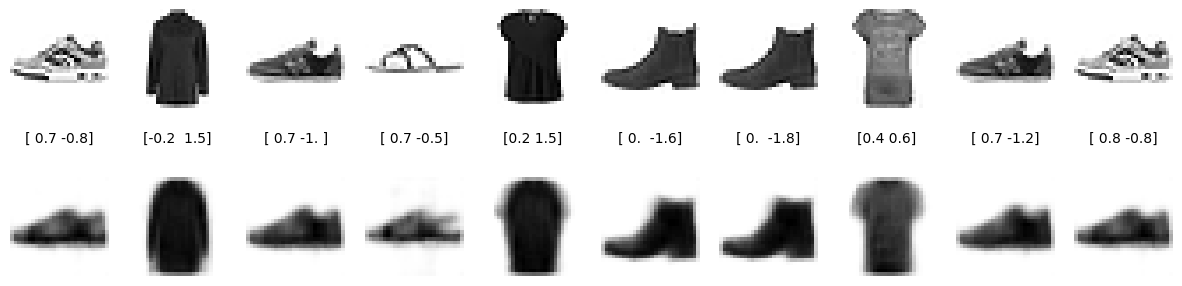

In [65]:
plot_random_samples(model)

Latent space with 5000 sample points
X: -3.705 ~ 3.067
Y: -2.998 ~ 2.619


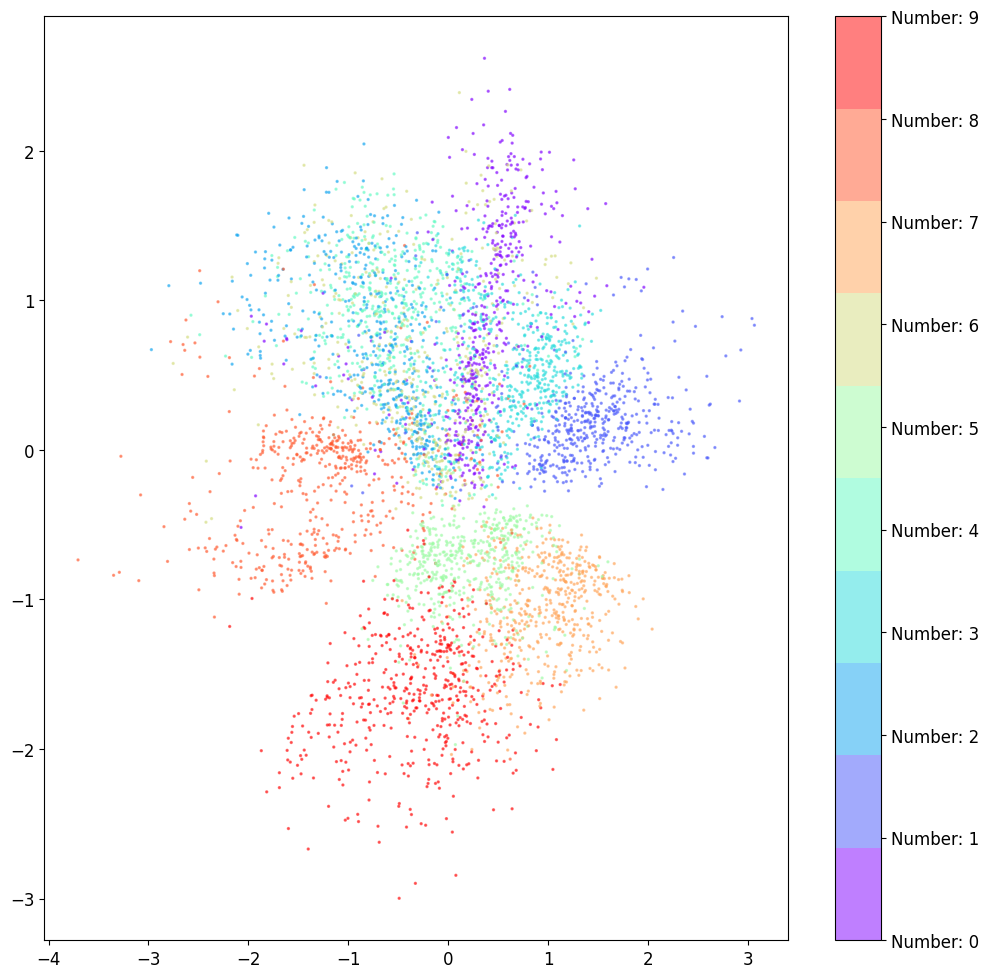

In [66]:
plot_latent(model, n_sample=5000)